In [ ]:
# https://github.com/ara-vardanyan

In [1]:
import numpy as np
import scipy.optimize
import scipy.signal
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial

## (i)

In [2]:
# initializing data

X = np.arange(0, 31)
Y = np.array([30, 35, 33, 32, 34, 37, 39, 38, 36, 36, 37, 39, 42, 45, 45, 41,
40, 39, 42, 44, 47, 49, 50, 49, 46, 48, 50, 53, 55, 54, 53])
N = len(X)

In [3]:
# defining function

def func(x, A, B, C, D):
    return A * np.cos(B * x) + C * x + D

In [4]:
params, params_covariance = scipy.optimize.curve_fit(func, X, Y)

print("Parameters (A, B, C, D):", params)

Parameters (A, B, C, D): [ 2.17172698  0.9093258   0.73248851 31.45277244]


In [5]:
fitted_values = func(X, *params)
least_squares_error = np.sum((fitted_values - Y) ** 2) / N

print("Least-squares error:", least_squares_error)

Least-squares error: 2.5367756342469523


## (ii)

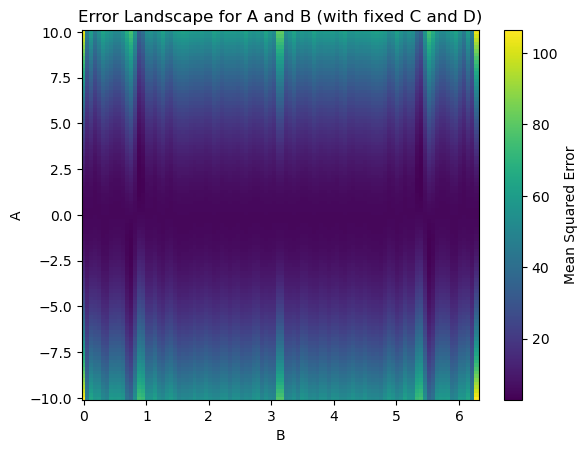

In [6]:
C, D = params[2], params[3]

# sweeping through parameter values
A_values = np.linspace(-10, 10, 100)
B_values = np.linspace(0, 2 * np.pi, 100)

AB_error_landscape = np.zeros((len(A_values), len(B_values)))

for i, A in enumerate(A_values):
    for j, B in enumerate(B_values):
        fitted_values = func(X, A, B, C, D)
        mse = np.sum((fitted_values - Y) ** 2) / N
        AB_error_landscape[i, j] = mse

# plotting the error landscape
plt.pcolor(B_values, A_values, AB_error_landscape, shading='auto')
plt.xlabel('B')
plt.ylabel('A')
plt.colorbar(label='Mean Squared Error')
plt.title('Error Landscape for A and B (with fixed C and D)')
plt.show()

In [7]:
# Flatten the error landscape and sort the errors
sorted_errors_idx = np.argsort(AB_error_landscape.flatten())

# Get the corresponding A and B values for the sorted errors
sorted_A_values = np.zeros(len(sorted_errors_idx))
sorted_B_values = np.zeros(len(sorted_errors_idx))

for i, idx in enumerate(sorted_errors_idx):
    sorted_A_values[i] = A_values[idx // len(B_values)]
    sorted_B_values[i] = B_values[idx % len(B_values)]

# Print the sorted A and B values along with their corresponding errors
print("Sorted A, B values and their corresponding errors:")
for i in range(10):
    print(f"A: {sorted_A_values[i]:.2f}, B: {sorted_B_values[i]:.2f}, Error: {AB_error_landscape.flatten()[sorted_errors_idx[i]]:.2f}")

Sorted A, B values and their corresponding errors:
A: 1.92, B: 0.89, Error: 2.92
A: 1.92, B: 5.39, Error: 2.92
A: 2.12, B: 0.89, Error: 2.92
A: 2.12, B: 5.39, Error: 2.92
A: 1.72, B: 0.89, Error: 2.95
A: 1.72, B: 5.39, Error: 2.95
A: 2.32, B: 0.89, Error: 2.97
A: 2.32, B: 5.39, Error: 2.97
A: 1.52, B: 0.89, Error: 3.03
A: 1.52, B: 5.39, Error: 3.03


With parameters C and D fixed and iterating through 100 different values of each A and B, we find that there are 4 minimas with an error of 2.92.
<br>
A: 1.92, B: 0.89, Error: 2.92
<br>
A: 1.92, B: 5.39, Error: 2.92
<br>
A: 2.12, B: 0.89, Error: 2.92
<br>
A: 2.12, B: 5.39, Error: 2.92

## (iii)

In [8]:
def sweep(param1_name, param1_values, param2_name, param2_values, fixed_params):
    error_landscape = np.zeros((len(param1_values), len(param2_values)))

    for i, p1 in enumerate(param1_values):
        for j, p2 in enumerate(param2_values):
            fitted_values = func(X, *fixed_params(p1, p2))
            mse = np.sum((fitted_values - Y) ** 2) / N
            error_landscape[i, j] = mse

    return error_landscape

In [9]:
A_values = np.linspace(-10, 10, 100)
B_values = np.linspace(0, 2 * np.pi, 100)
C_values = np.linspace(-1, 1, 100)
D_values = np.linspace(20, 60, 100)

error_landscapes = [
    ('C', C_values, 'D', D_values, lambda p1, p2: (params[0], params[1], p1, p2)),
    ('B', B_values, 'D', D_values, lambda p1, p2: (params[0], p1, params[2], p2)),
    ('B', B_values, 'C', C_values, lambda p1, p2: (params[0], p1, p2, params[3])),
    ('A', A_values, 'D', D_values, lambda p1, p2: (p1, params[1], params[2], p2)),
    ('A', A_values, 'C', C_values, lambda p1, p2: (p1, params[1], p2, params[3])),
    ('A', A_values, 'B', B_values, lambda p1, p2: (p1, p2, params[2], params[3])),
]

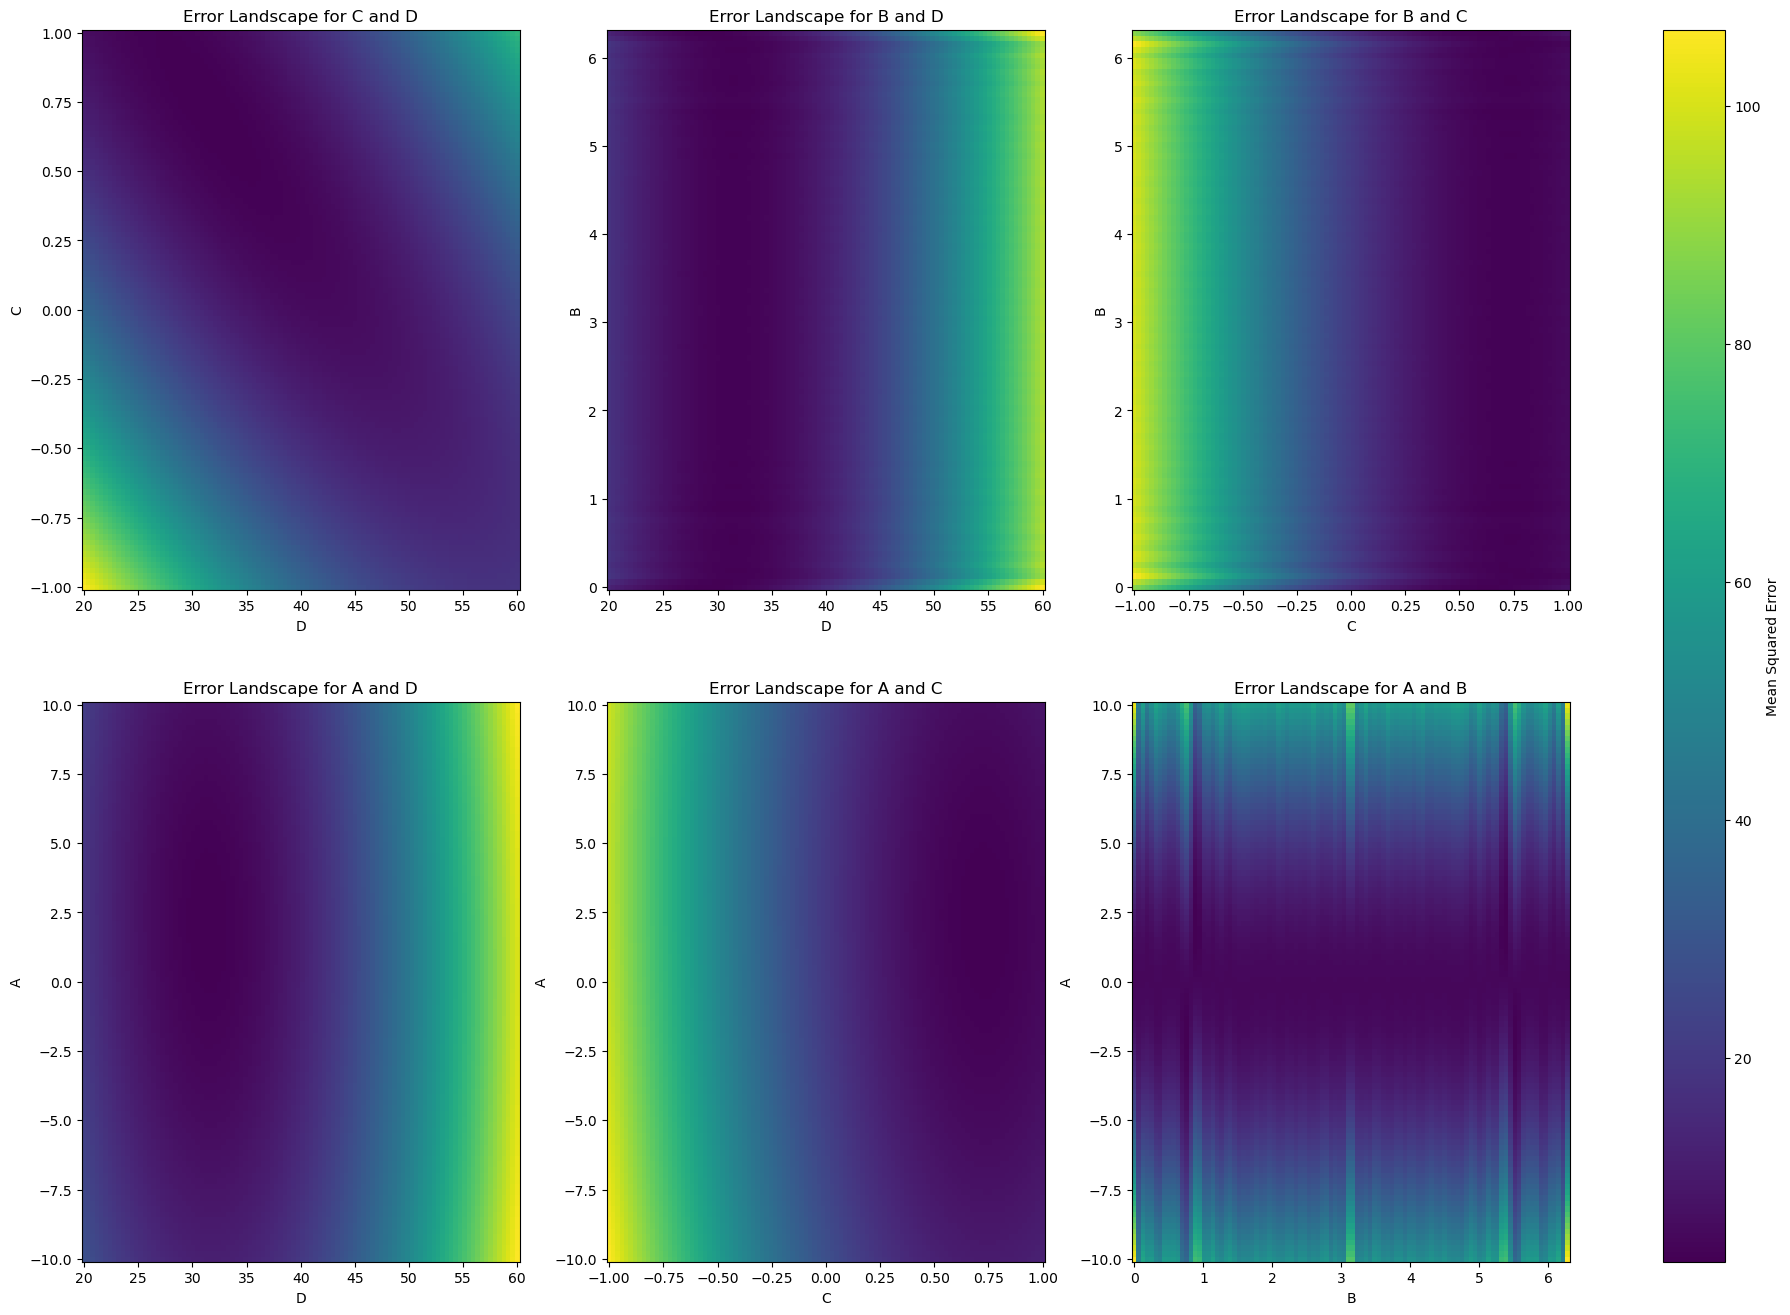

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(24, 16))

for i, (ax, (param1_name, param1_values, param2_name, param2_values, fixed_params)) in enumerate(zip(axes.flat, error_landscapes)):
    error_landscape = sweep(param1_name, param1_values, param2_name, param2_values, fixed_params)
    pc = ax.pcolor(param2_values, param1_values, error_landscape, shading='auto', cmap='viridis')
    ax.set_xlabel(param2_name)
    ax.set_ylabel(param1_name)
    ax.set_title(f'Error Landscape for {param1_name} and {param2_name}')

fig.colorbar(pc, ax=axes.ravel().tolist(), label='Mean Squared Error')
plt.show()

In [11]:
def find_top_5_minima(error_landscape, param1_values, param2_values):
    comparator = np.less
    minima_indices = scipy.signal.argrelextrema(error_landscape, comparator)

    minima_positions = [(param1_values[i], param2_values[j]) for i, j in zip(*minima_indices)]
    minima_errors = error_landscape[minima_indices]

    sorted_minima = sorted(zip(minima_positions, minima_errors), key=lambda x: x[1])

    return sorted_minima[:5]

top_5_minima_per_landscape = [find_top_5_minima(sweep(param1_name, param1_values, param2_name, param2_values, fixed_params), param1_values, param2_values)
                               for param1_name, param1_values, param2_name, param2_values, fixed_params in error_landscapes]

for i, (param_combination, minima) in enumerate(zip(error_landscapes, top_5_minima_per_landscape)):
    param1_name, _, param2_name, _, _ = param_combination
    print(f'Top 5 local minima for {param1_name} and {param2_name}:')
    for j, (position, error) in enumerate(minima):
        print(f'  {j+1}. {param1_name}={position[0]:.2f}, {param2_name}={position[1]:.2f}, Error={error:.2f}')
    print()


Top 5 local minima for C and D:
  1. C=0.74, D=31.31, Error=2.54
  2. C=0.72, D=31.72, Error=2.56
  3. C=0.76, D=30.91, Error=2.62
  4. C=0.70, D=32.12, Error=2.66
  5. C=0.78, D=30.51, Error=2.77

Top 5 local minima for B and D:
  1. B=0.89, D=31.31, Error=2.94
  2. B=5.39, D=31.31, Error=2.94
  3. B=0.89, D=31.72, Error=3.02
  4. B=5.39, D=31.72, Error=3.02
  5. B=0.89, D=30.91, Error=3.19

Top 5 local minima for B and C:
  1. B=0.89, C=0.74, Error=2.95
  2. B=5.39, C=0.74, Error=2.95
  3. B=0.89, C=0.72, Error=2.97
  4. B=5.39, C=0.72, Error=2.97
  5. B=0.89, C=0.76, Error=3.18

Top 5 local minima for A and D:
  1. A=2.12, D=31.31, Error=2.56
  2. A=2.12, D=31.72, Error=2.61
  3. A=2.12, D=30.91, Error=2.84
  4. A=2.12, D=32.12, Error=2.98
  5. A=2.32, D=30.51, Error=3.44

Top 5 local minima for A and C:
  1. A=2.12, C=0.74, Error=2.55
  2. A=2.12, C=0.72, Error=2.61
  3. A=2.12, C=0.76, Error=2.73
  4. A=2.12, C=0.70, Error=2.92
  5. A=2.12, C=0.78, Error=3.16

Top 5 local minima f

In [12]:
# Split data into training and test sets
X_train, Y_train = X[:20], Y[:20]
X_test, Y_test = X[20:], Y[20:]

# Fit models
linear_fit = Polynomial.fit(X_train, Y_train, 1)
parabola_fit = Polynomial.fit(X_train, Y_train, 2)
poly19_fit = Polynomial.fit(X_train, Y_train, 19)

# Calculate predictions
linear_Y_train = linear_fit(X_train)
parabola_Y_train = parabola_fit(X_train)
poly19_Y_train = poly19_fit(X_train)

linear_Y_test = linear_fit(X_test)
parabola_Y_test = parabola_fit(X_test)
poly19_Y_test = poly19_fit(X_test)

# Calculate least-squares errors
def least_squares_error(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2) / len(y_true)

models = ["linear", "parabola", "19th-degree polynomial"]
train_errors = [
    least_squares_error(Y_train, linear_Y_train),
    least_squares_error(Y_train, parabola_Y_train),
    least_squares_error(Y_train, poly19_Y_train),
]
test_errors = [
    least_squares_error(Y_test, linear_Y_test),
    least_squares_error(Y_test, parabola_Y_test),
    least_squares_error(Y_test, poly19_Y_test),
]

# Print the errors
print("Least-squares errors on training data:")
for model, error in zip(models, train_errors):
    print(f"{model}: {error:.4f}")

print("\nLeast-squares errors on test data:")
for model, error in zip(models, test_errors):
    print(f"{model}: {error:.4f}")

Least-squares errors on training data:
linear: 5.0299
parabola: 4.5179
19th-degree polynomial: 0.0000

Least-squares errors on test data:
linear: 11.3141
parabola: 75.9277
19th-degree polynomial: 38454308324079644442624.0000


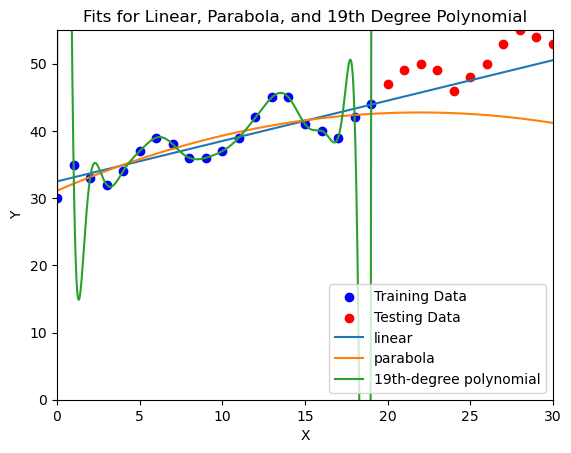

In [13]:
# Plot the fits over the train and test data
plt.scatter(X_train, Y_train, label='Training Data', color='blue')
plt.scatter(X_test, Y_test, label='Testing Data', color='red')

X_plot = np.linspace(0, 30, 1000)
for name, model in zip(models, [linear_fit, parabola_fit, poly19_fit]):
    Y_plot = model(X_plot)
    plt.plot(X_plot, Y_plot, label=name)

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fits for Linear, Parabola, and 19th Degree Polynomial')
plt.xlim(0, 30)
plt.ylim(0, 55)
plt.show()

In [14]:
# Split data into training and test sets
X_train = np.concatenate((X[:10], X[-10:]))
Y_train = np.concatenate((Y[:10], Y[-10:]))
X_test, Y_test = X[10:20], Y[10:20]

# Fit models
linear_fit = Polynomial.fit(X_train, Y_train, 1)
parabola_fit = Polynomial.fit(X_train, Y_train, 2)
poly19_fit = Polynomial.fit(X_train, Y_train, 19)

# Calculate predictions
linear_Y_train = linear_fit(X_train)
parabola_Y_train = parabola_fit(X_train)
poly19_Y_train = poly19_fit(X_train)

linear_Y_test = linear_fit(X_test)
parabola_Y_test = parabola_fit(X_test)
poly19_Y_test = poly19_fit(X_test)

# Calculate least-squares errors
def least_squares_error(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2) / len(y_true)

models = ["linear", "parabola", "19th-degree polynomial"]
train_errors = [
    least_squares_error(Y_train, linear_Y_train),
    least_squares_error(Y_train, parabola_Y_train),
    least_squares_error(Y_train, poly19_Y_train),
]
test_errors = [
    least_squares_error(Y_test, linear_Y_test),
    least_squares_error(Y_test, parabola_Y_test),
    least_squares_error(Y_test, poly19_Y_test),
]

# Print the errors
print("Least-squares errors on training data:")
for model, error in zip(models, train_errors):
    print(f"{model}: {error:.4f}")

print("\nLeast-squares errors on test data:")
for model, error in zip(models, test_errors):
    print(f"{model}: {error:.4f}")

Least-squares errors on training data:
linear: 3.4287
parabola: 3.4256
19th-degree polynomial: 0.0000

Least-squares errors on test data:
linear: 8.6454
parabola: 8.4437
19th-degree polynomial: 180926.4988


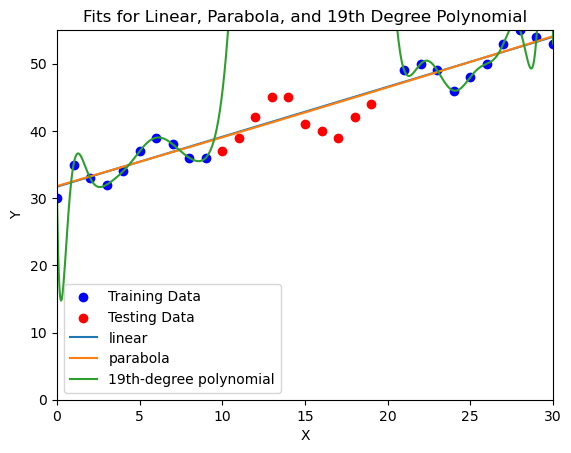

In [15]:
# Plot the fits over the train and test data
plt.scatter(X_train, Y_train, label='Training Data', color='blue')
plt.scatter(X_test, Y_test, label='Testing Data', color='red')

X_plot = np.linspace(0, 30, 1000)
for name, model in zip(models, [linear_fit, parabola_fit, poly19_fit]):
    Y_plot = model(X_plot)
    plt.plot(X_plot, Y_plot, label=name)

plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fits for Linear, Parabola, and 19th Degree Polynomial')
plt.xlim(0, 30)
plt.ylim(0, 55)
plt.show()